### Calculates price-equilibrium in the market for blockchain records,  with and without the lightning network.

### Includes symbolic calculations and plots for specific parameter values.

### Focuses on symmetric transfer-rate and power-law transfer-size.

In [1]:
import numpy as np
import sympy
sympy.init_printing(use_unicode=True)
from sympy import *
from sympy.solvers import solve
from IPython.display import display
from typing import Callable
from sympy.utilities.lambdify import lambdify, implemented_function

%matplotlib inline
import matplotlib.pyplot as plt

def simplified(exp, title=None):
    simp = simplify(exp)
    if simplified.LOG:
        if title: display(title,simp)
        else: display(simp)
    return simp
simplified.LOG = True

def firstOrderCondition(exp, var):
    diffExp = simplified(diff(exp, var))
    solutions = solve(diffExp, var)
    if firstOrderCondition.LOG:
        display(solutions)
    return solutions
firstOrderCondition.LOG = True
  
class Result(object):   # a class for holding results of calculations
    def __repr__(self): return self.__dict__.__repr__()
    def display(self):
        for k,v in sorted(self.__dict__.items()):
            display(k,v)
    def subs(self, params):
        ans = Result()
        for k,v in sorted(self.__dict__.items()):
            if hasattr(v,"subs"):
                ans.__dict__[k] = v.subs(params).evalf()
            else:
                ans.__dict__[k] = v
        return ans

In [2]:
a,p,r,b,vmax,zmin,zmax,beta = symbols('a \\phi r z v_{\max} z_{\min} z_{\max} \\beta', positive=True,finite=True,real=True)
w,T,D,L,n,Supply = symbols('w T \\Delta \\ell n \\tau', positive=True,finite=True,real=True)

params = {
    L: 10,           # total transfers per day 
    D: 6,            # delta transfers per day 
    beta: 0.01,      # value / transfer-size
    r: 4/100/365,    # interest rate per day
    a: 1.1,          # records per reset tx
    Supply: 288000,  # records per day
    zmin: 0.001,     # min transfer size (for power law distribution)
    zmax: 1,         # max transfer size (for uniform distribution)
}

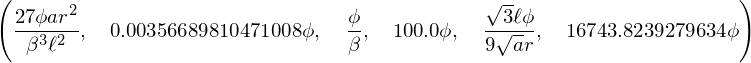

In [3]:
tNL = 27 * a * r**2 / L**2 / beta**3 * p
tNB = p/beta
tLB = L*p/(27*a*r**2)**(Rational(1,2))
(tNL, tNL.subs(params), tNB, tNB.subs(params), tLB, tLB.subs(params).evalf())

# Demand curves

'demandWithLightning'

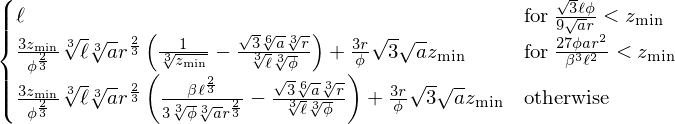

'demandWithoutLightning'

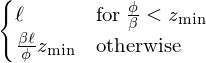

'txsBlockchain'

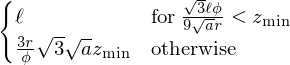

'txsLightning'

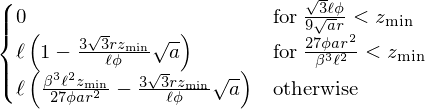

'txsTotal'

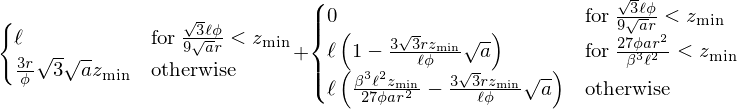

'demandWithLightning'

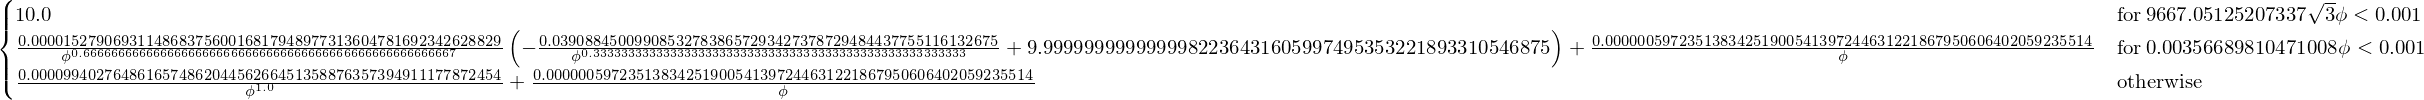

'demandWithoutLightning'

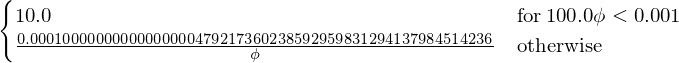

'txsBlockchain'

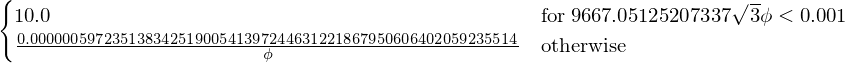

'txsLightning'

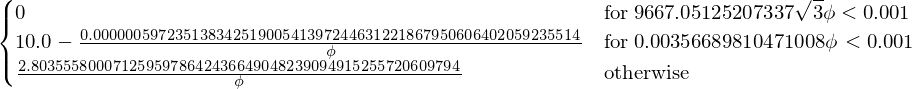

'txsTotal'

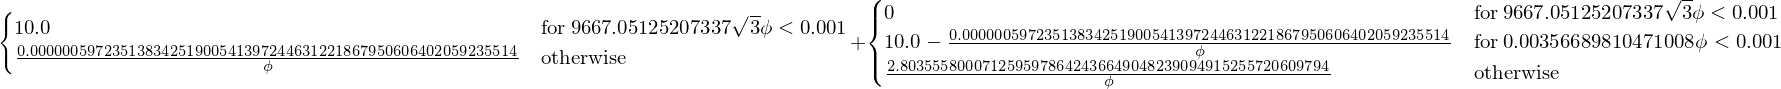

In [14]:
### Calculate the demand-curves assuming power-law distribution:
def calculateDemandsPowerlaw():
    result = Result()
    result.demandWithoutLightning = Piecewise( 
        (L, tNB < zmin), 
        (L*zmin/tNB, True))
    result.demandWithLightning = Piecewise( 
        (L, tLB < zmin), 
        (3 * zmin * (L*a*r**2/p**2)**Rational(1,3)*(zmin**Rational(-1,3)-tLB**Rational(-1,3)) + L*zmin/tLB, tNL < zmin), 
        (3 * zmin * (L*a*r**2/p**2)**Rational(1,3)*( tNL**Rational(-1,3)-tLB**Rational(-1,3)) + L*zmin/tLB, True))
    result.txsBlockchain = Piecewise( 
        (L, tLB < zmin), 
        (L*zmin/tLB, True))
    result.txsLightning = Piecewise( 
        (0, tLB < zmin), 
        (L*(1-zmin/tLB), tNL < zmin), 
        (L*(zmin/tNL-zmin/tLB), True))
    result.txsTotal = result.txsBlockchain + result.txsLightning
    return result

demandsPowerlaw = calculateDemandsPowerlaw()
demandsPowerlaw.display()
demandsPowerlawNumeric = demandsPowerlaw.subs(params)
demandsPowerlawNumeric.display()

# Price curves

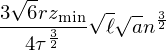

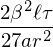

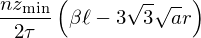

In [27]:
Demand2 = 3 * zmin * (L*a*r**2/p**2)**Rational(1,3)*(zmin**Rational(-1,3)-tLB**Rational(-1,3)) + L*zmin/tLB
Price2 = simplified(solve (n/2*Demand2 - Supply, p)[0])
Condition2a = simplified(solve(tLB.subs(p, Price2) - zmin,n)[0])
Condition2b = simplified(solve(zmin - tNL.subs(p, Price2),n)[0])

Demand3 = 3 * zmin * (L*a*r**2/p**2)**Rational(1,3)*( tNL**Rational(-1,3)-tLB**Rational(-1,3))
Price3 = simplified(solve (n/2*Demand3 - Supply, p)[0])
Condition3a = simplified(solve(tNL.subs(p, Price2) - zmin,n)[0])

'priceWithLightning'

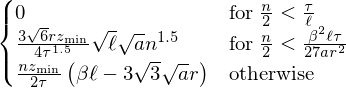

'priceWithoutLightning'

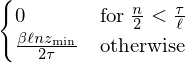

'priceWithLightning'

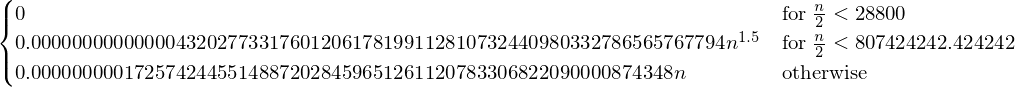

'priceWithoutLightning'

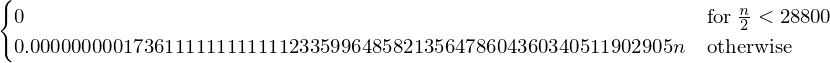

In [28]:
### Calculate the demand-curves assuming power-law distribution:
def calculatePricesPowerlaw():
    result = Result()
    result.priceWithoutLightning = Piecewise( 
        (0, n/2 < Supply/L), 
        (n*L*beta*zmin/2/Supply, True))
    result.priceWithLightning = Piecewise( 
        (0, n/2 < Supply/L), 
        (3*sqrt(6)*r*zmin/4/Supply**(3/2)*sqrt(L*a)*n**(3/2), n/2 < beta**2*L*Supply/27/a/r**2), 
        (n*zmin/2/Supply*(beta*L - 3*sqrt(3*a)*r), True))
#     result.txsBlockchain = Piecewise( 
#         (L, tLB < zmin), 
#         (L*zmin/tLB, True))
#     result.txsLightning = Piecewise( 
#         (0, tLB < zmin), 
#         (L*(1-zmin/tLB), tNL < zmin), 
#         (L*(zmin/tNL-zmin/tLB), True))
#     result.txsTotal = result.txsBlockchain + result.txsLightning
    return result

pricesPowerlaw = calculatePricesPowerlaw()
pricesPowerlaw.display()
pricesPowerlawNumeric = pricesPowerlaw.subs(params)
pricesPowerlawNumeric.display()

# Plots

In [35]:
plotSymmetric = True
plotAsymmetric = False

linewidth = 3
def plotSymbolic(xRange, yExpression, xVariable, style, label):
    plt.plot(xRange, [yExpression.subs(xVariable,xValue) for xValue in xRange], style, label=label, linewidth=linewidth)

def plotDemandCurves(priceRange, demandWithoutLightning, demandWithLightning):
    """
    Plot the expected demand of a single pair vs. the price.
    """
    global plotSymmetric, plotAsymmetric
    plotSymbolic(priceRange, demandWithoutLightning, p, "r.",label="w.o. lightning")
    plotSymbolic(priceRange, demandWithLightning, p,  "b--",label="with lightning")
    plt.gca().set_ylim(-1,11)
    plt.xlabel("blockchain fee $\\phi$  [bitcoins]")
    plt.ylabel("Demand of a single pair [records/day]")
    plt.legend(loc=0)

def plotTxsCurves(priceRange, demandWithoutLightning, demandWithLightning):
    """
    Plot the expected transfer-count of a single pair vs. the price.
    """
    plotSymbolic(priceRange, demandWithoutLightning, p, "r.",label="w.o. lightning")
    plotSymbolic(priceRange, demandWithLightning.txsBlockchain,  p,  "g-.",label="with lightning; blockchain")
    plotSymbolic(priceRange, demandWithLightning.txsLightning, p,  "b--",label="with lightning; lightning")
    plotSymbolic(priceRange, demandWithLightning.txsTotal, p,  "k-",label="with lightning; total")
    plt.gca().set_ylim(-1,11)
    plt.xlabel("blockchain fee $\\phi$  [bitcoins]")
    plt.ylabel("# Transactions per day")
    plt.legend(loc=0)

def plotPriceCurves(nRange, priceWithoutLightning, priceWithLightning):
    """
    Plot the price vs. the number of users.
    """
    global plotSymmetric, plotAsymmetric
    plotSymbolic(nRange, priceWithoutLightning, n, "r.",label="w.o. lightning")
    plotSymbolic(nRange, priceWithLightning, n,  "b--",label="with lightning")
    plt.xlabel("Number of users $n$")
    plt.ylabel("Market-equilibrium price $\\phi$ [bitcoins/record]")
    plt.legend(loc=0)

def plotMarketTxsCurves(nRange, demandWithoutLightning, demandWithLightning, priceWithoutLightning, priceWithLightning):
    """
    Plot the expected transfer-count in the entire market vs. the number of users.
    """
    plotSymbolic(nRange, (n/2)*demandWithoutLightning.subs(p,priceWithoutLightning), n, "r.",label="w.o. lightning")
    plotSymbolic(nRange, (n/2)*demandWithLightning.txsBlockchain.subs(p,priceWithLightning), n,  "g-.",label="with lightning; blockchain")
    plotSymbolic(nRange, (n/2)*demandWithLightning.txsLightning.subs (p,priceWithLightning), n,  "b--",label="with lightning; lightning")
    plotSymbolic(nRange, (n/2)*demandWithLightning.txsTotal.subs (p,priceWithLightning), n,  "k-",label="with lightning; total")
    plt.xlabel("Number of users $n$")
    plt.ylabel("# Transactions per day")
    plt.legend(loc=0)

def plotSymbolic3(xRange, yExpression, xVariable, style, label):
    plt.plot(xRange, [yExpression.subs(xVariable,xValue)*params[Supply] for xValue in xRange], style, label=label)
    
def plotRevenueCurves(nRange, priceWithoutLightning, priceAsymmetric, priceSymmetric):
    global plotSymmetric, plotAsymmetric
    plotSymbolic3(nRange, priceWithoutLightning, n, "r-",label="no lightning")
    if plotAsymmetric and priceAsymmetric:
        plotSymbolic3(nRange, priceAsymmetric, n,  "b.",label="asymmetric")
    if plotSymmetric and priceSymmetric:
        plotSymbolic3(nRange, priceSymmetric, n,  "g--",label="symmetric")
    plt.xlabel("Number of users $n$")
    plt.ylabel("Miners' revenue [bitcoins/day]")
    plt.legend(loc=0)    
    

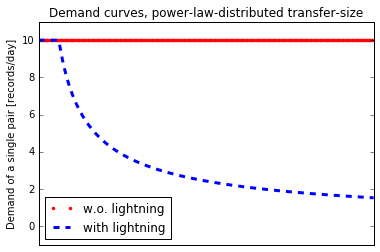

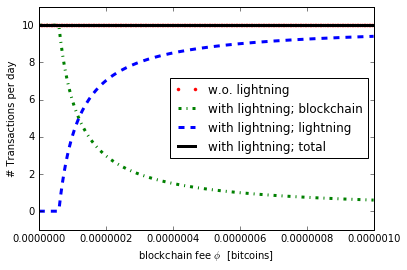

In [6]:
priceRange = np.linspace(0,1e-6,200)
plotDemandCurves(priceRange, demandsPowerlawNumeric.demandWithoutLightning, demandsPowerlawNumeric.demandWithLightning)
plt.title("Demand curves, power-law-distributed transfer-size")
plt.axes().get_xaxis().set_visible(False)
plt.savefig('../graphs/demand-curves-powerlaw-small-price.pdf', format='pdf', dpi=1000); plt.show()
plotTxsCurves(priceRange, demandsPowerlawNumeric.demandWithoutLightning, demandsPowerlawNumeric)
plt.savefig('../graphs/txs-pair-powerlaw-small-price.pdf', format='pdf', dpi=1000); plt.show()

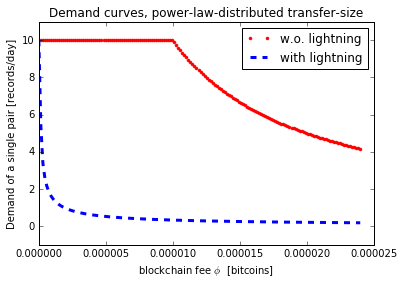

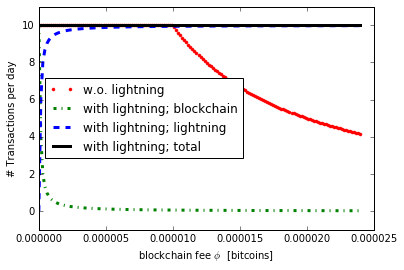

In [7]:
priceRange = np.linspace(0,2.4e-5,160)
plotDemandCurves(priceRange, demandsPowerlawNumeric.demandWithoutLightning, demandsPowerlawNumeric.demandWithLightning)
plt.title("Demand curves, power-law-distributed transfer-size")
#plt.axes().get_xaxis().set_visible(False)
plt.savefig('../graphs/demand-curves-powerlaw-medium-price.pdf', format='pdf', dpi=1000); plt.show()
plotTxsCurves(priceRange, demandsPowerlawNumeric.demandWithoutLightning, demandsPowerlawNumeric)
plt.savefig('../graphs/txs-pair-powerlaw-medium-price.pdf', format='pdf', dpi=1000); plt.show()

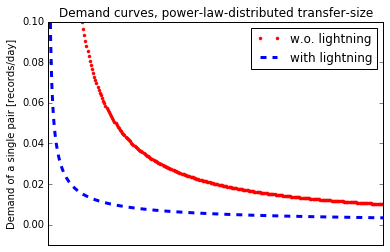

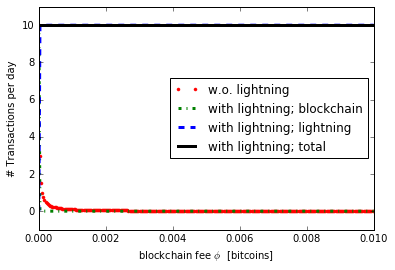

In [8]:
priceRange = np.linspace(0,0.01,300)
plotDemandCurves(priceRange, demandsPowerlawNumeric.demandWithoutLightning, demandsPowerlawNumeric.demandWithLightning)
plt.title("Demand curves, power-law-distributed transfer-size")
plt.axes().get_xaxis().set_visible(False)
plt.gca().set_ylim(-0.01,0.1)
plt.savefig('../graphs/demand-curves-powerlaw-large-price.pdf', format='pdf', dpi=1000); plt.show()
plotTxsCurves(priceRange, demandsPowerlawNumeric.demandWithoutLightning, demandsPowerlawNumeric)
plt.savefig('../graphs/txs-pair-powerlaw-large-price.pdf', format='pdf', dpi=1000); plt.show()

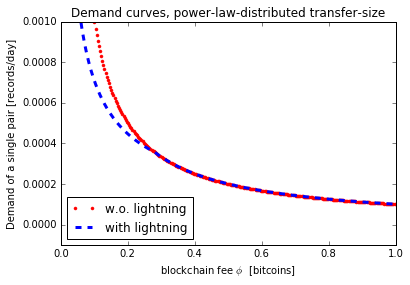

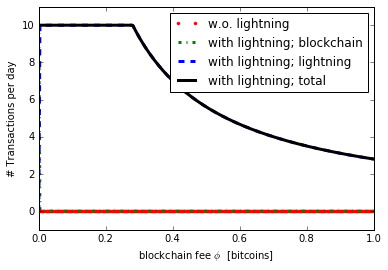

In [9]:
priceRange = np.linspace(0,1,300)
plotDemandCurves(priceRange, demandsPowerlawNumeric.demandWithoutLightning, demandsPowerlawNumeric.demandWithLightning)
plt.title("Demand curves, power-law-distributed transfer-size")
#plt.axes().get_xaxis().set_visible(False)
plt.gca().set_ylim(-0.0001,0.001)
plt.savefig('../graphs/demand-curves-powerlaw-huge-price.pdf', format='pdf', dpi=1000); plt.show()
plotTxsCurves(priceRange, demandsPowerlawNumeric.demandWithoutLightning, demandsPowerlawNumeric)
plt.savefig('../graphs/txs-pair-powerlaw-huge-price.pdf', format='pdf', dpi=1000); plt.show()

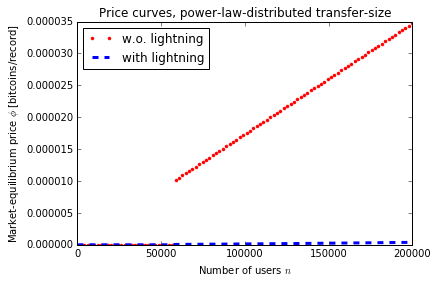

In [30]:
nRange = np.linspace(0,2e5,100)
plotPriceCurves(nRange, pricesPowerlawNumeric.priceWithoutLightning, pricesPowerlawNumeric.priceWithLightning)
plt.title("Price curves, power-law-distributed transfer-size")
plt.savefig('../graphs/price-curves-powerlaw-smalln.pdf', format='pdf', dpi=1000)

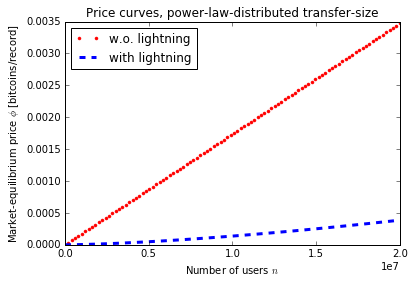

In [32]:
nRange = np.linspace(0,2e7,100)
plotPriceCurves(nRange, pricesPowerlawNumeric.priceWithoutLightning, pricesPowerlawNumeric.priceWithLightning)
plt.title("Price curves, power-law-distributed transfer-size")
plt.savefig('../graphs/price-curves-powerlaw-mediumn.pdf', format='pdf', dpi=1000)

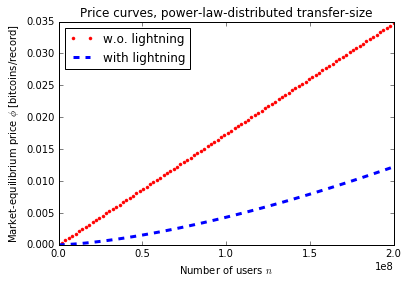

In [33]:
nRange = np.linspace(0,2e8,100)
plotPriceCurves(nRange, pricesPowerlawNumeric.priceWithoutLightning, pricesPowerlawNumeric.priceWithLightning)
plt.title("Price curves, power-law-distributed transfer-size")
plt.savefig('../graphs/price-curves-powerlaw-largen.pdf', format='pdf', dpi=1000)

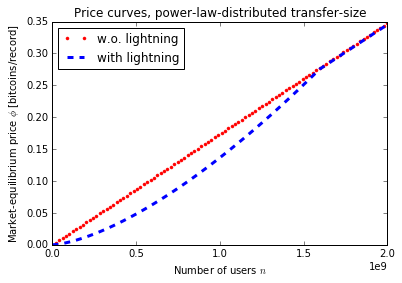

In [34]:
nRange = np.linspace(0,2e9,100)
plotPriceCurves(nRange, pricesPowerlawNumeric.priceWithoutLightning, pricesPowerlawNumeric.priceWithLightning)
plt.title("Price curves, power-law-distributed transfer-size")
plt.savefig('../graphs/price-curves-powerlaw-hugen.pdf', format='pdf', dpi=1000)

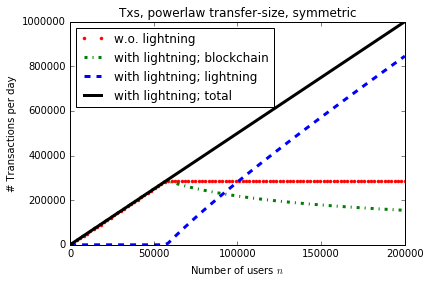

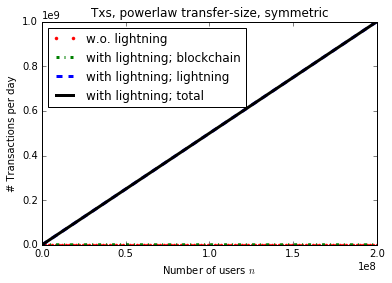

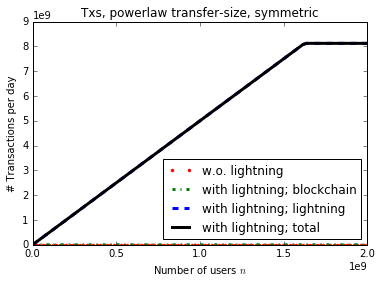

In [39]:
nRange = np.linspace(0,2e5,100)
plotMarketTxsCurves(nRange, demandsPowerlawNumeric.demandWithoutLightning, demandsPowerlawNumeric, pricesPowerlawNumeric.priceWithoutLightning, pricesPowerlawNumeric.priceWithLightning)
plt.title("Txs, powerlaw transfer-size, symmetric")
plt.savefig('../graphs/txs-market-powerlaw-symmetric-smalln.pdf', format='pdf', dpi=1000)
plt.show()
nRange = np.linspace(0,2e8,100)
plotMarketTxsCurves(nRange, demandsPowerlawNumeric.demandWithoutLightning, demandsPowerlawNumeric, pricesPowerlawNumeric.priceWithoutLightning, pricesPowerlawNumeric.priceWithLightning)
plt.title("Txs, powerlaw transfer-size, symmetric")
plt.savefig('../graphs/txs-market-powerlaw-symmetric-largen.pdf', format='pdf', dpi=1000)
plt.show()
nRange = np.linspace(0,2e9,100)
plotMarketTxsCurves(nRange, demandsPowerlawNumeric.demandWithoutLightning, demandsPowerlawNumeric, pricesPowerlawNumeric.priceWithoutLightning, pricesPowerlawNumeric.priceWithLightning)
plt.title("Txs, powerlaw transfer-size, symmetric")
plt.savefig('../graphs/txs-market-powerlaw-symmetric-hugen.pdf', format='pdf', dpi=1000)
plt.show()